<table class="buttons" align="center">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/dl-ub-summer-school/2019/blob/master/seminar2/word2vec/seminar2_word2vec.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Google Colab дээр нээх</a>
    </td>
    <td>
        <a target="_blank" href="https://github.com/dl-ub-summer-school/2019/blob/master/seminar2/word2vec/seminar2_word2vec.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub дээр нээх</a>
    </td>
    <td>
        <a target="_blank" href="https://sites.google.com/view/dlub/dl-ub-2019"><img src="https://avatars0.githubusercontent.com/u/52651086?s=32&v=4">Зуны сургалтын вебсайт</a>
    </td>
</table>

In [0]:
import numpy
from collections import deque

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import sys

numpy.random.seed(2019)


![alt text](http://mccormickml.com/assets/word2vec/training_data.png)

  Data Preprocessing

In [0]:
class InputData:
    def __init__(self, file_name, min_count):
        self.input_file_name = file_name
        self.get_words(min_count)
        self.word_pair_catch = deque()
        self.init_sample_table()
        print(' Ялгаатай Үгийн тоо: %d' % len(self.word2id))
        print(' Текст дэх нийт үгийн тоо: %d' % (self.sentence_length))
    
    def get_words(self, min_count):
        self.input_file = open(self.input_file_name)
        self.sentence_length = 0
        self.sentence_count = 0
        word_frequency = dict()
        for line in self.input_file:
            self.sentence_count += 1
            line = line.strip().split(' ')
            self.sentence_length += len(line)
            for w in line:
                try:
                    word_frequency[w] += 1         
                except:
                    word_frequency[w] = 1
        self.word2id = dict()
        self.id2word = dict()
        wid = 0
        self.word_frequency = dict()
        for w, c in word_frequency.items():
            # Тухайн үг текст дотор min_count aaс бага орсон байвал хасна
            if c < min_count:  
                self.sentence_length -= c
                continue
            self.word2id[w] = wid
            self.id2word[wid] = w
            self.word_frequency[wid] = c
            wid += 1
        self.word_count = len(self.word2id)

    # Negative sampling сонгож авах table үүсгэх
    # Текст дэх үг сонгогдох магадлалын тархалт нь тухайн үгсийн давтамжуудыг 3/4 
    #  зэрэгт дэвшүүлж нормальчилна. 
    def init_sample_table(self):
        self.sample_table = []
        sample_table_size = 1e8
        pow_frequency = numpy.array(list(self.word_frequency.values()))**0.75
        words_pow = sum(pow_frequency)
        ratio = pow_frequency / words_pow
        count = numpy.round(ratio * sample_table_size)
        for wid, c in enumerate(count):
            self.sample_table += [wid] * int(c)
        self.sample_table = numpy.array(self.sample_table)
    
    # Модел сургах хос үгнүүд авах
    def get_batch_pairs(self, batch_size, window_size):
        while len(self.word_pair_catch) < batch_size:
            sentence = self.input_file.readline()
            if sentence is None or sentence == '':
                self.input_file = open(self.input_file_name)
                sentence = self.input_file.readline() 
            word_ids = []
            for word in sentence.strip().split(' '):
                try:
                    word_ids.append(self.word2id[word])
                except:
                    continue
            for i, u in enumerate(word_ids):
                for j, v in enumerate(
                        word_ids[max(i - window_size, 0):i + window_size]):
                    assert u < self.word_count
                    assert v < self.word_count
                    if i == j:
                        continue
                    self.word_pair_catch.append((u, v))
        batch_pairs = []
        for _ in range(batch_size):
            batch_pairs.append(self.word_pair_catch.popleft())
        return batch_pairs
    # Санамсаргүй negative sample ууд сонгож авах
    def get_neg_v_neg_sampling(self, pos_word_pair, count):
        neg_v = numpy.random.choice(
            self.sample_table, size=(len(pos_word_pair), count)).tolist()
        return neg_v
    # Нийт хосуудыг тооцоолох
    def evaluate_pair_count(self, window_size):
      print('length:',self.sentence_length)
      return self.sentence_length * (2 * window_size -1) - (
            self.sentence_count - 1) * (1 + window_size) * window_size


In [0]:
filename = "news_politics.txt"
!wget -O {filename} "https://github.com/dl-ub-summer-school/2019/blob/master/Seminar2/Word2Vec/news_politics.txt"

In [5]:
# Сургалтын өгөдлийнхөө мэдээллийг харъя
InputData('news_politics.txt',5)

 Ялгаатай Үгийн тоо: 149
 Текст дэх нийт үгийн тоо: 2435


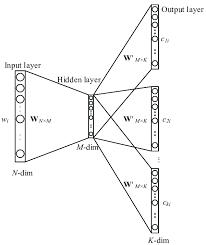

In [0]:
# SKipgram модел үүсгэе. Энэ класс нь pytorch ийн nn.Module аас удамшиж түүний функцуудыг ашиглана.
class SkipGramModel(nn.Module):
    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.v_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)
        self.init_emb()
# Эмбэддин матрицийн утгуудыг өгөх

    def init_emb(self):
        initrange = 0.5 / self.emb_dimension
        self.u_embeddings.weight.data.uniform_(-initrange, initrange)
        self.v_embeddings.weight.data.uniform_(-0, 0)
# Тухайн өгөгдлийн багцын алдагдал буюу Loss ийг бодох
    def forward(self, pos_u, pos_v, neg_v):
        # pos_u = [batch_size,]  pos_v= [ batch_size, ]  neg_v= [batch_size ,5]
        emb_u = self.u_embeddings(pos_u)    # [batch_size x emb_dimension] 
        emb_v = self.v_embeddings(pos_v)    #  [batch_size x emb_dimension]
        #  Энд Loss function тэгшитгэлээ бичиж өгнө.

        # Elemente wise multiplication
        score = torch.mul(emb_u, emb_v)   #[batch_size x emb_dimension] 
        score = torch.sum(score, dim=1)            #[batch_size]
        score = F.logsigmoid(score)               # [batch_size]

        neg_emb_v = self.v_embeddings(neg_v)   # [50x5x15]
        neg_score = torch.bmm(neg_emb_v, emb_u.unsqueeze(2)).squeeze()  # ([50x5x15],x [50x15x1])  -> [50x5x1] -> [50x5] 
        neg_score = F.logsigmoid(-1 * neg_score)   # [50x1]
        return -1 * (torch.sum(score)+torch.sum(neg_score)) # 1

                    Word2Vec model

In [0]:
class Word2Vec:
    """ 
        input_file_name: Унших файлыг зааж өгнө. Нэг мөр бүрт өгүүлбэрүүд байна.
        output_file_name: Name of the final embedding file.
        emb_dimension: Word Embedding хийх векторийн хэмжээс .
        batch_size: Нэг давталтад хичнээн өгөгдөл ашиглахыг тодорхойлно.
        window_size: 
        iteration: Сургалтыг хэдэн удаа давтахыг тодорхойлно.
        initial_lr: Сургах хурд.
        min_count: Үгийн хамгийн бага давтамж. Үүнээс бага давтагдаж байгаа үгийг сургахад ашиглахгүй.
    """
  
    def __init__(self,
                 input_file_name,
                 output_file_name,
                 emb_dimension=100,
                 batch_size=50,
                 window_size=5,
                 iteration=1,
                 initial_lr=0.025,
                 min_count=1):
        
        self.data = InputData(input_file_name, min_count)
        self.output_file_name = output_file_name
        self.emb_size = len(self.data.word2id)
        self.emb_dimension = emb_dimension
        self.batch_size = batch_size
        self.window_size = window_size
        self.iteration = iteration
        self.initial_lr = initial_lr
        self.skip_gram_model = SkipGramModel(self.emb_size, self.emb_dimension)
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.skip_gram_model.cuda()
        self.optimizer = optim.SGD(
            self.skip_gram_model.parameters(), lr=self.initial_lr)

    def train(self):
        pair_count = self.data.evaluate_pair_count(self.window_size)
        batch_count = self.iteration * pair_count / self.batch_size
        process_bar = tqdm(range(int(batch_count)))
        for i in process_bar:
            pos_pairs = self.data.get_batch_pairs(self.batch_size,
                                                  self.window_size)
            neg_v = self.data.get_neg_v_neg_sampling(pos_pairs, 5) # Negative sampling индексүүд    
            pos_u = [pair[0] for pair in pos_pairs]  # center word индексүүд
            pos_v = [pair[1] for pair in pos_pairs]  # context word индексүүд 

            pos_u = Variable(torch.LongTensor(pos_u))
            pos_v = Variable(torch.LongTensor(pos_v))
            neg_v = Variable(torch.LongTensor(neg_v))
            if self.use_cuda:
                pos_u = pos_u.cuda()
                pos_v = pos_v.cuda()
                neg_v = neg_v.cuda()

            self.optimizer.zero_grad()
            
            # NN model train hiih heseg
            
            loss = self.skip_gram_model.forward(pos_u, pos_v, neg_v)
            loss.backward()
            self.optimizer.step()

            process_bar.set_description("Loss: %0.8f, lr: %0.6f" %
                                        (loss.data.item(),
                                         self.optimizer.param_groups[0]['lr']))
            if i * self.batch_size % 10000 == 0:
                 lr = self.initial_lr * (1.0 - 1.0 * i / batch_count)
                 for param_group in self.optimizer.param_groups:
                     param_group['lr'] = lr
    def embed(self,word):
        if word in self.data.word2id:
            return self.skip_gram_model.u_embeddings(torch.tensor([self.data.word2id[word]]).cuda())
        else:
            print('Энэ үг санд байхгүй байна.')
            return None

In [0]:
# Hyperparameters
emb_dimension=40
batch_size=128
window_size=4
iteration=20
initial_lr=0.025
min_count=5

In [9]:
w2v = Word2Vec(input_file_name='news_politics.txt', output_file_name='embed.txt',emb_dimension=emb_dimension, \
                batch_size=batch_size, window_size=window_size,iteration=iteration, initial_lr=initial_lr,min_count=min_count)


 Ялгаатай Үгийн тоо: 149
 Текст дэх нийт үгийн тоо: 2435


In [0]:
# Текст дэх үгнүүдийн индексийг хэвлэж харъя
for i,y in w2v.data.word2id.items():
    print(i+': '+str(y))  

In [11]:
# үгсийн сан дахь үгийн векторийг хэвлэж харъя
w2v.embed('фейсбүк')

Энэ үг санд байхгүй байна.


In [0]:
w2v.train()

In [0]:
# Дараах үгсийн векторийг дүрслэе
visualizewords=['ерөнхийлөгч','элбэгдорж','уих','дархан',
                'улаанбаатар','эрдэнэт','офшор','хандив',
                'мөнгө','тангараг','дайчин','үнэнч']

Word2vec ээр сургасан үгнүүдийнхээ векторийг харахын тулд бид хэмжээсийг багасгах шаардлагатай. Ингэхдээ PCA ашиглая

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [0]:
temp=numpy.zeros((len(visualizewords),emb_dimension), dtype='float32')
for j,k in enumerate(visualizewords):
    if w2v.embed(k) is not None:
        temp[j]=w2v.embed(k).cpu().detach().numpy()[0]
pca = PCA(n_components = 2)
temp=temp-numpy.mean(temp,axis=0)
a=pca.fit_transform(temp)

In [0]:
# Хэмжээс нь багассан өгөгдлийн хэлбэрийг харъя
print(a.shape)

(12, 2)


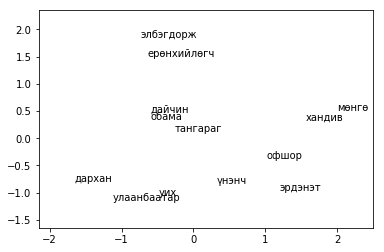

In [0]:
# Сонгож авсан үгнүүдээ хавтгайд байгуулж харъя
plt.figure()
for i in range(len(visualizewords)):
    plt.text(a[i][0],a[i][1],visualizewords[i])
    
plt.xlim((numpy.min(a[:,0])-0.5, numpy.max(a[:,0])+0.5))
plt.ylim((numpy.min(a[:,1])-0.5, numpy.max(a[:,1])+0.5))
plt.show()